We aim to build an effective model that can detect whether a mushroom is chanterelle or not. We move from binary classification to categorical classification and added a  'false chanterelle(Mushrooms that are chanterelle lookalike)' dataset so that our model is more robust and can detect false chanterelle mushrooms as well. 

First, we import all the necessary libraries required for this project. Apart from the popular data manipulation library, we are also modules from Keras to build our Convulational Neural Network, preprocess images and regularization purposes.

In [1]:
import os
import numpy as np
from keras.utils import load_img, img_to_array
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from keras.layers import BatchNormalization, Dense, Dropout
from keras.regularizers import l2
from keras.applications.inception_v3 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


The function below loads an image from a given path, resizes it to a specified target size (default is 299x299), converts it to a NumPy array, expands its dimensions to match the model input shape, and applies preprocessing specific to the InceptionV3 model before returning the preprocessed image.

In [2]:
# Function to preprocess images
def preprocess_image(image_path, target_size=(299, 299)):
    image = load_img(image_path, target_size=target_size)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)  # Use preprocess_input from InceptionV3
    return image


This function extracts features from an image using the InceptionV3 deep learning model. It takes an image array as input and utilizes the provided model to predict and return the extracted features.

In [3]:
# Function to extract features using VGG16
def extract_features(img_array, model):
    features = model.predict(img_array)
    return features


This code loads the InceptionV3 model pre-trained on ImageNet dataset and creates a feature extraction model called feature_model. It extracts image features using the 'mixed10' layer's output. 

In [4]:
from keras.applications.inception_v3 import InceptionV3
inception_model = InceptionV3(weights='imagenet')
feature_model = Model(inputs=inception_model.input, 
                      outputs=inception_model.get_layer('mixed10').output)


We mount Google drive to access the dataset

In [ ]:
# Mount Google Drive to access the dataset
# from google.colab import drive
# drive.mount('/content/drive')

In the code below, we deefine the paths to our dataset. We are using the `os` library to do this. 

In [5]:
# Define the dataset directories
base_dir = './'
chanterelle_dir = os.path.join(base_dir, 'chanterelle')
non_chanterelle_dir = os.path.join(base_dir, 'non-chanterelle')
false_chanterelle_dir = os.path.join(base_dir, 'false_chanterelle')

This code extracts features from images of `chanterelles` and creates corresponding labels. It loops through the images in the 'chanterelle_dir' directory, preprocesses each image, extracts features using 'feature_model,' flattens the features, and assigns a label of `1` to indicate chanterelle images.

In [6]:
# Extract features for each image and create labels
features = []
labels = []

# Process chanterelle images
for image_path in os.listdir(chanterelle_dir):
    img = preprocess_image(os.path.join(chanterelle_dir, image_path))
    feat = extract_features(img, feature_model)
    features.append(feat.flatten())
    labels.append(1)  # Chanterelle

1/1 [==============================] - 0s 85ms/step


The same feature extraction is happenning in the code below for `non-chanterelle` images. We are also giving it a label `0` to indicate non chanterelle images.

In [7]:
# Process non-chanterelle images
for image_path in os.listdir(non_chanterelle_dir):
    img = preprocess_image(os.path.join(non_chanterelle_dir, image_path))
    feat = extract_features(img, feature_model)
    features.append(feat.flatten())
    labels.append(0)

1/1 [==============================] - 0s 91ms/step


And here we do the same process for `false chanterelle` images.

In [8]:
# Process false chanterelle images
for image_path in os.listdir(false_chanterelle_dir):
    img = preprocess_image(os.path.join(false_chanterelle_dir, image_path))
    feat = extract_features(img, feature_model)
    features.append(feat.flatten())
    labels.append(2)  # Label for false chanterelle

1/1 [==============================] - 0s 89ms/step


This code converts the extracted features and labels into NumPy arrays for further processing and analysis.

In [9]:
# Convert to numpy arrays
features = np.array(features)
labels = np.array(labels)

We are saving the features and labels array in order to save time. We can load these np array to run our CNN instead of extracting feature for every run.

In [10]:
np.save('./features_3.npy', features)
np.save('./labels_3.npy', labels)

In [6]:
# features = np.load('./features_3.npy')
# labels = np.load('./labels_3.npy')

This code below splits the data into training and testing sets using the train_test_split function. It reserves 20% of the data for testing, ensures reproducibility with random_state, and maintains class balance with stratify. Finally, it prints the shapes of the resulting training and test data arrays.

In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

# Output the shapes of the split data
print(f'Training data shape: {X_train.shape}')
print(f'Test data shape: {X_test.shape}')

Training data shape: (1135, 131072)
Test data shape: (284, 131072)


This code below defines a neural network model for multi-class classification. It consists of multiple dense layers with ReLU activation, batch normalization, and dropout for regularization. The output layer has three neurons, indicating it's designed for a classification task with three classes. The model is compiled with the Adam optimizer and uses sparse categorical cross-entropy as the loss function while tracking accuracy as a metric.

In [11]:
# Create the neural network model for multi-class classification
def create_nn_model(input_shape):
    model = Sequential([
        Dense(512, activation='relu', kernel_regularizer=l2(0.001), input_shape=(input_shape,)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(3, activation='softmax')  # Change to 3 output neurons for 3 classes
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



This code creates a neural network model for multi-class classification using the `create_nn_model` function. It then sets up `callbacks` for model checkpointing and early stopping.

The `nn_model` is trained on the training data `(X_train and y_train)` with a batch size of `64` for a maximum of `15 epochs`. During training, two callbacks are applied: one for saving the best model based on validation performance and another for early stopping with a patience of 2 epochs to prevent overfitting.

In [12]:
# Create and train the neural network
nn_model = create_nn_model(X_train.shape[1])

# Create a callback that saves the best model
checkpoint_cb = ModelCheckpoint("multi_class_model_new.keras", save_best_only=True)

# Create early stopping callback
early_stopping_cb = EarlyStopping(patience=2, restore_best_weights=True)

# Train the model with callbacks
nn_history = nn_model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.2,
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/15
15/15 [==============================] - 10s 529ms/step - loss: 3.5671 - accuracy: 0.4978 - val_loss: 10.2747 - val_accuracy: 0.3436
Epoch 2/15
15/15 [==============================] - 7s 488ms/step - loss: 4.1854 - accuracy: 0.6256 - val_loss: 8.0692 - val_accuracy: 0.3524
Epoch 3/15
15/15 [==============================] - 7s 496ms/step - loss: 4.2060 - accuracy: 0.6850 - val_loss: 5.4902 - val_accuracy: 0.4449
Epoch 4/15
15/15 [==============================] - 7s 496ms/step - loss: 3.9381 - accuracy: 0.7236 - val_loss: 5.0858 - val_accuracy: 0.4978
Epoch 5/15
15/15 [==============================] - 7s 499ms/step - loss: 3.6224 - accuracy: 0.7985 - val_loss: 4.0523 - val_accuracy: 0.6476
Epoch 6/15
15/15 [==============================] - 7s 485ms/step - loss: 3.3268 - accuracy: 0.8579 - val_loss: 3.6341 - val_accuracy: 0.6916
Epoch 7/15
15/15 [==============================] - 7s 493ms/step - loss: 3.0892 - accuracy: 0.8689 - val_loss: 3.3882 - val_accuracy: 0.7004
Epoc

Now we evaluate this model on unseen data. The code below gives the test accuracy which is `87.32%`.

In [9]:
# Evaluate the model on the test set
test_loss, test_accuracy = nn_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")


9/9 [==============================] - 0s 25ms/step - loss: 2.0687 - accuracy: 0.8732
Test accuracy: 87.32%



This code extracts training and validation accuracy, as well as training and validation loss, from the nn_history object. It then plots these metrics over the training epochs, showing how they change over time.

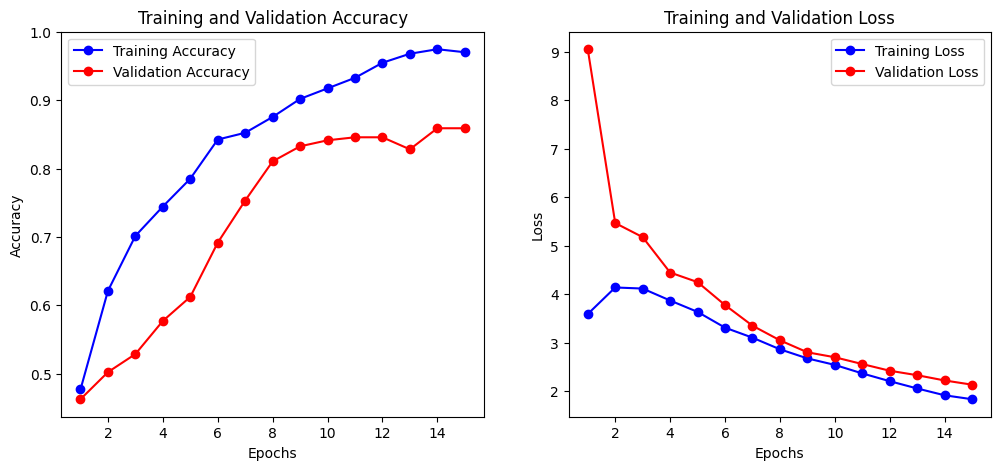

In [10]:
# Extract accuracy and loss from the history object
accuracy = nn_history.history['accuracy']
val_accuracy = nn_history.history['val_accuracy']
loss = nn_history.history['loss']
val_loss = nn_history.history['val_loss']
epochs = range(1, len(accuracy) + 1)

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


The left subplot displays the training and validation accuracy, while the right subplot displays the training and validation loss. The blue line represents training data, and the red line represents validation data.